In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from preprocess import load_clean_data, data_stats, create_features, create_features_labels
from plots import plot_validation_diagram, plot_samples, plot_avg, plot_ewma
from IPython.display import display

from evaluate import evaluate_ae_models, evaluate_seq_models, evaluate_dummy

Using TensorFlow backend.


In [5]:
data = load_clean_data(range(48))

Error while parsing file inxed=2
Error while parsing file inxed=4
Error while parsing file inxed=44


In [6]:
df = data_stats(data)
df.sum().sort_values(ascending=False)

N    79358
L     8075
V     7069
R     6005
/     3620
A     2543
F      802
f      260
j      229
a      150
E      106
J       83
Q       17
e       16
S        2
n        0
B        0
r        0
?        0
dtype: int64

In [2]:
df[['A', 'R', '/', 'V', 'L', 'N']]

NameError: name 'df' is not defined

In [7]:
data_range = list(range(37))
data_range.remove(2)
data_range.remove(4)
data = load_clean_data(data_range)
val_range = list(range(37,48))
val_range.remove(44)
validation = load_clean_data(val_range)

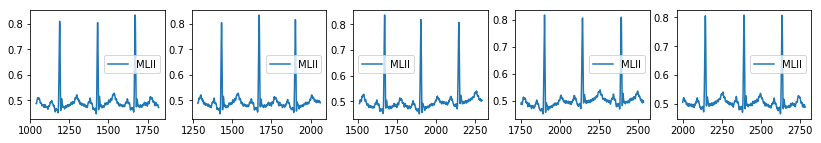

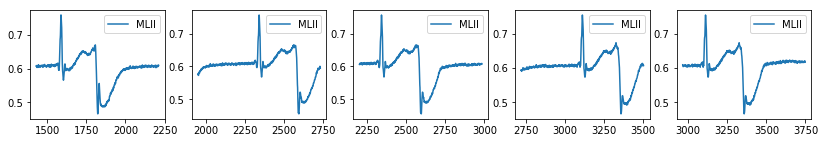

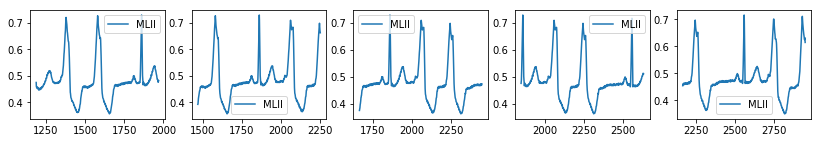

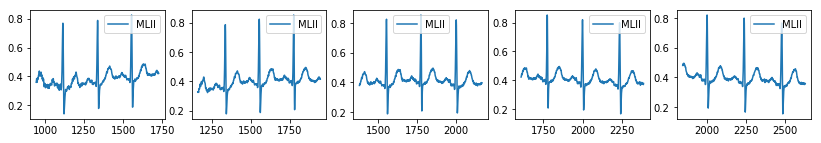

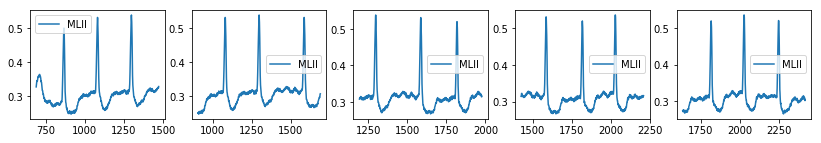

In [18]:
plot_samples(data[-10:-5])

In [22]:
#plot_avg(data[0]['signals'], 400)

In [23]:
#plot_ewma(data[0]['signals'], 400)

### Create small train/test set

In [45]:
lb = LabelBinarizer()
x_train_all, labels = create_features_labels(data, 784, non_beats_per_beat = 2, beat_types=['A', 'N'])
y_train_all = lb.fit_transform(labels)

x_test_all, labels = create_features_labels(validation, 784, non_beats_per_beat = 2, beat_types=['A', 'N'])
y_test_all = lb.transform(labels)

In [48]:
x_train_all.shape, x_test_all.shape

((166101, 784), (60711, 784))

In [49]:
x_train, _, y_train, _ = train_test_split(x_train_all, y_train_all, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test_all, y_test_all, test_size = .9)

In [50]:
x_train.shape, x_test.shape

((16610, 784), (6071, 784))

In [12]:
ann = validation[1]['annotations']
sig = validation[1]['signals']

In [14]:
#ann[ann['Type'] == 'A'][:10]

### DummyClassifier

In [15]:
dummy = evaluate_dummy(x_train, x_test, y_train, y_test, lb.classes_, ann, sig)

### Check NN autoencoder

Running autoencoder with config: [784, [], 64]
Successfully loaded weights


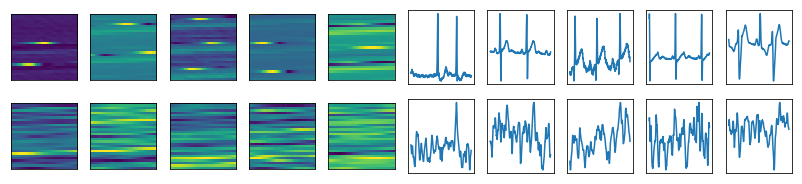

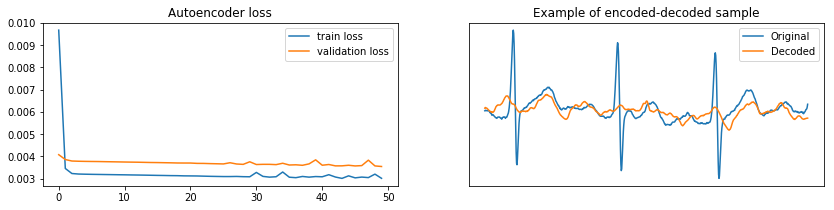

Evaluating model with fc: [3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.81      0.76      0.79      1794
         NB       0.90      0.96      0.93      4071

avg / total       0.84      0.87      0.86      6071



/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


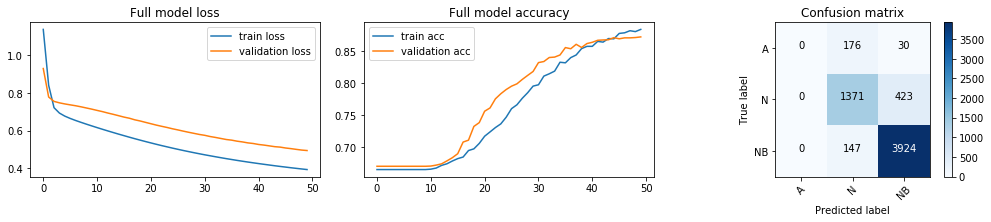

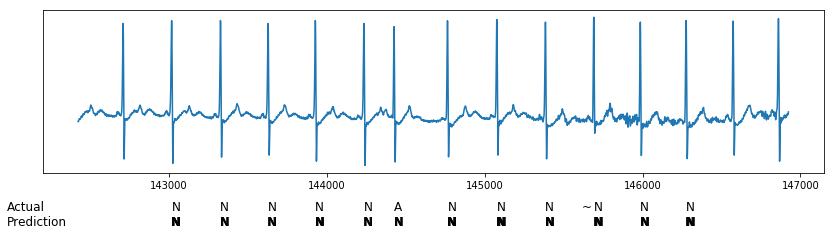

Evaluating model with fc: [32, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.79      0.82      0.81      1794
         NB       0.92      0.95      0.94      4071

avg / total       0.85      0.88      0.87      6071



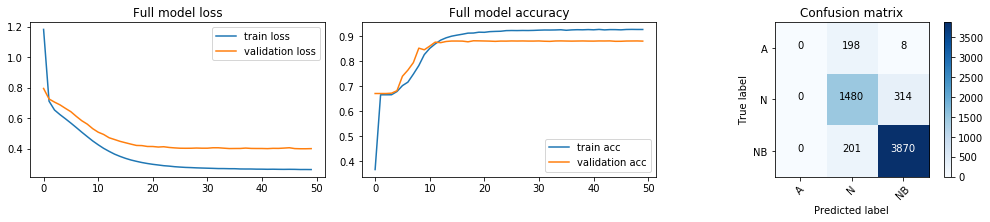

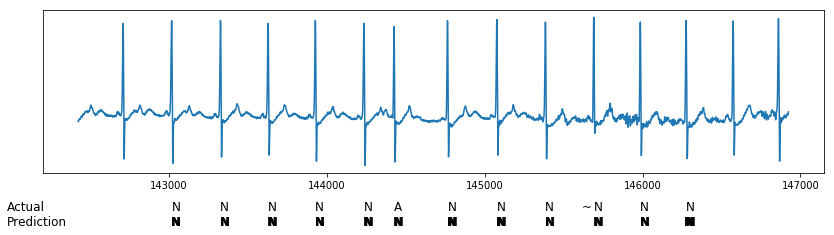

Evaluating model with fc: [64, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.79      0.82      0.81      1794
         NB       0.92      0.95      0.94      4071

avg / total       0.85      0.88      0.87      6071



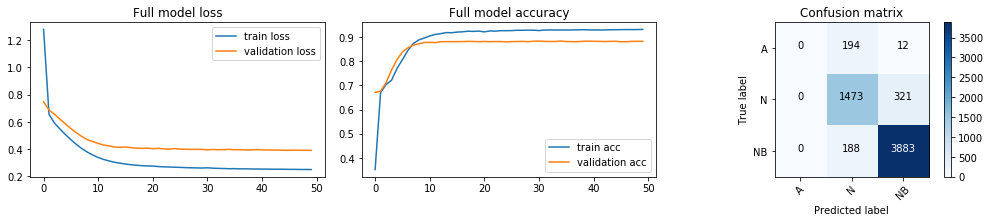

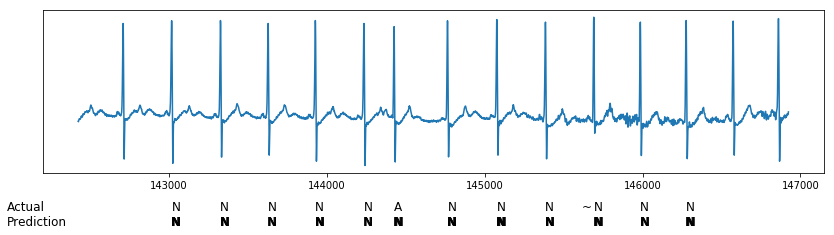

Running autoencoder with config: [784, [256, 128], 64]
Successfully loaded weights


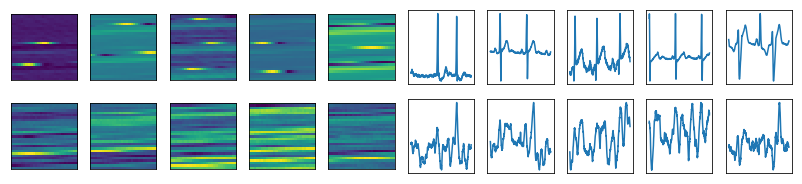

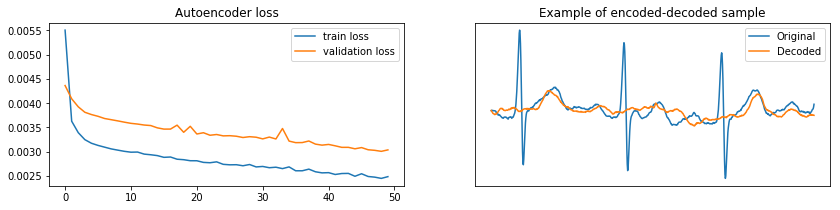

Evaluating model with fc: [3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.81      0.80      0.80      1794
         NB       0.91      0.97      0.94      4071

avg / total       0.85      0.88      0.87      6071



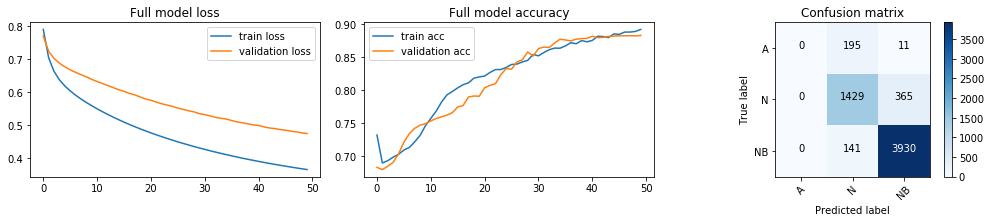

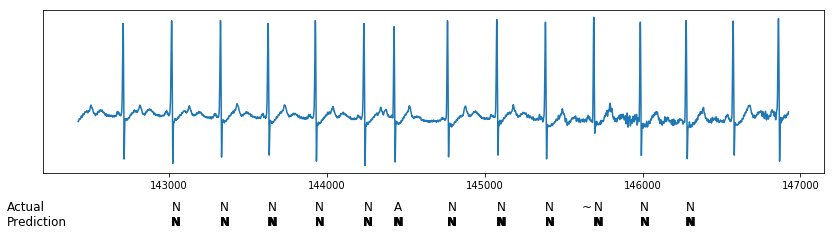

Evaluating model with fc: [32, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.81      0.87      0.84      1794
         NB       0.94      0.96      0.95      4071

avg / total       0.87      0.90      0.88      6071



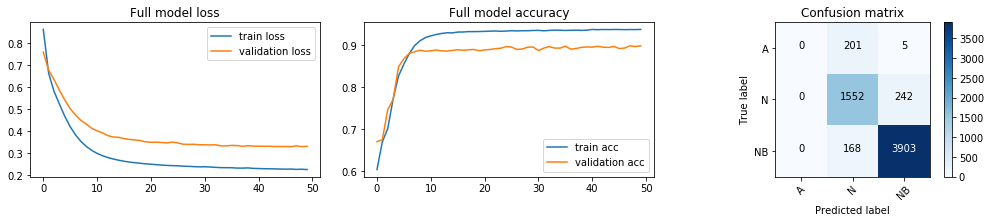

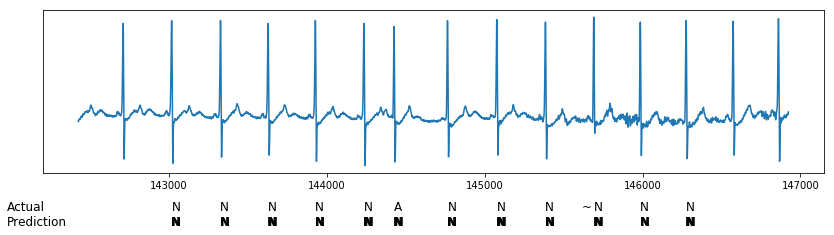

Evaluating model with fc: [64, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.81      0.85      0.83      1794
         NB       0.93      0.96      0.95      4071

avg / total       0.87      0.89      0.88      6071



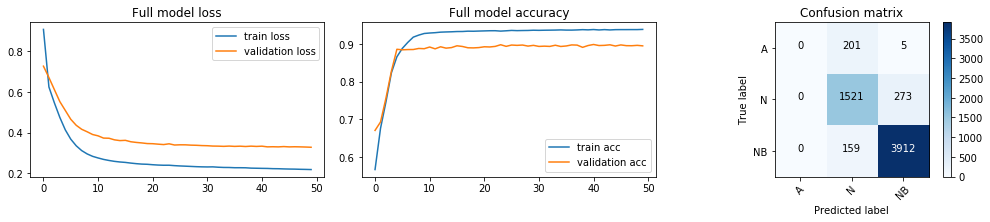

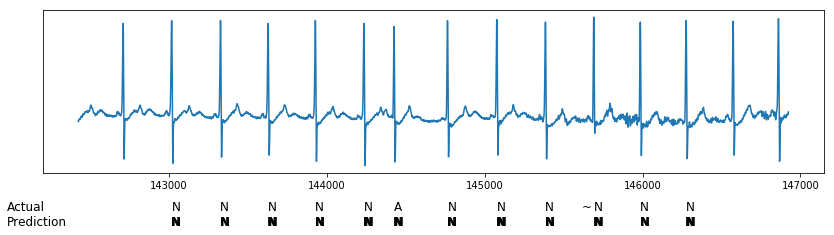

In [19]:
config = {
    'use_conv': False,
#     'ae' : [ [784,[], 64] ],
#     'fc' : [ [3] ]
    'ae' : [ [784,[], 64], [784, [256, 128], 64]],
    'fc' : [ [3], [32,3], [64,3] ]

}
nn_models = evaluate_ae_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                               ae_epochs=50, full_model_epochs=20, load_prev_ae=True, load_prev_full=False)

### Check CONV autoencoder

(28, 28) [16, 8, 8] (4, 4)
Running autoencoder with config: [(28, 28), [16, 8, 8], (4, 4)]
Successfully loaded weights


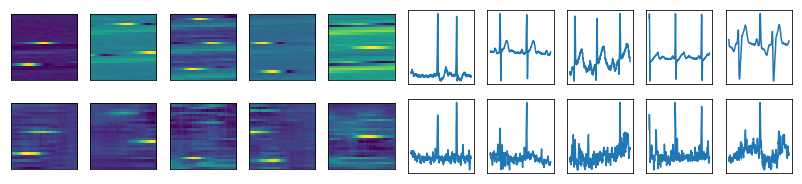

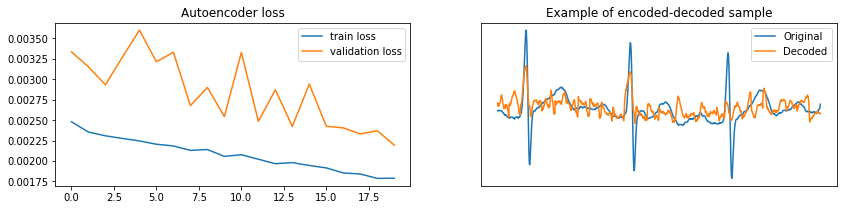

Evaluating model with fc: [3]


/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.83      0.86      0.84      1794
         NB       0.93      0.97      0.95      4071

avg / total       0.87      0.90      0.89      6071



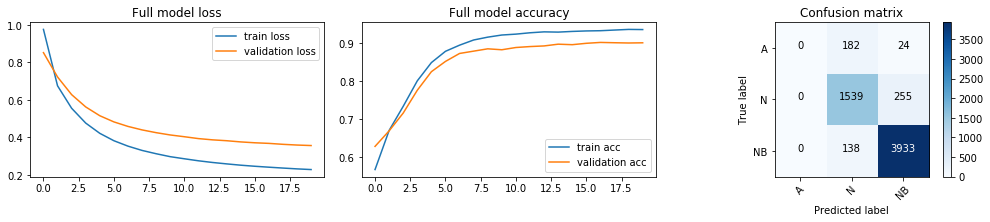

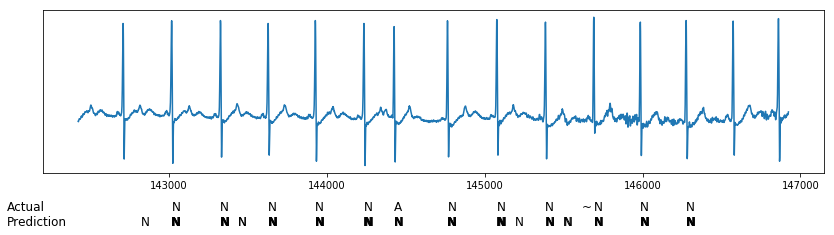

Evaluating model with fc: [64, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.84      0.90      0.87      1794
         NB       0.96      0.98      0.97      4071

avg / total       0.89      0.92      0.91      6071



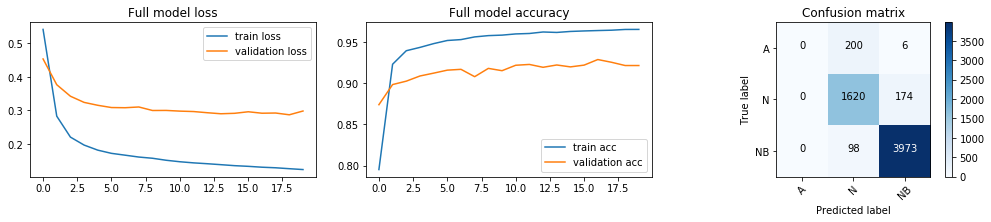

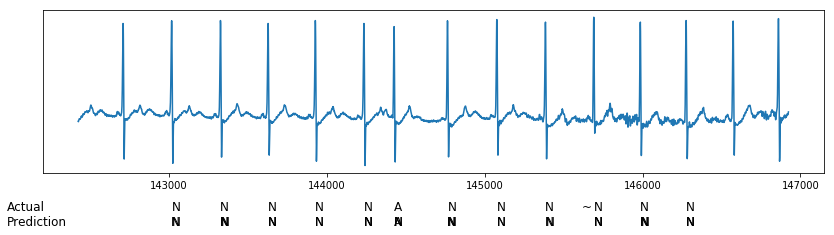

Evaluating model with fc: [128, 3]
             precision    recall  f1-score   support

          A       0.00      0.00      0.00       206
          N       0.85      0.92      0.88      1794
         NB       0.97      0.97      0.97      4071

avg / total       0.90      0.93      0.91      6071



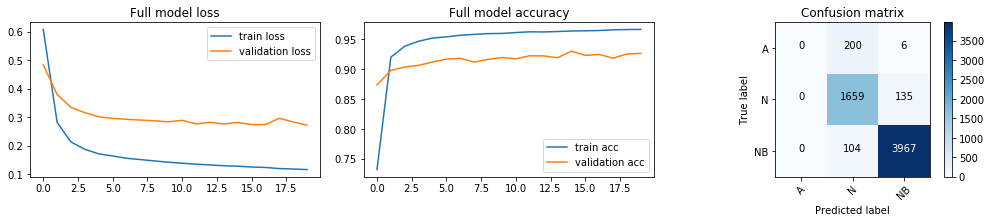

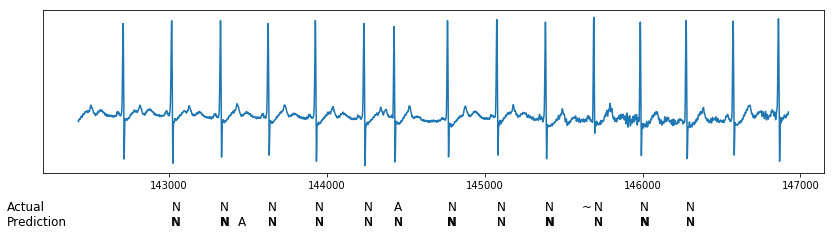

Evaluating model with fc: [1024, 3]
             precision    recall  f1-score   support

          A       1.00      0.01      0.03       206
          N       0.87      0.94      0.90      1794
         NB       0.97      0.98      0.98      4071

avg / total       0.94      0.94      0.92      6071



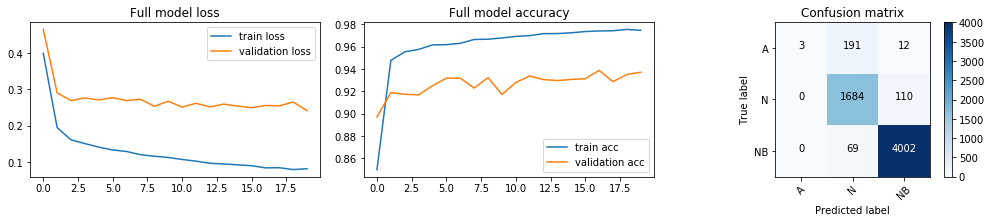

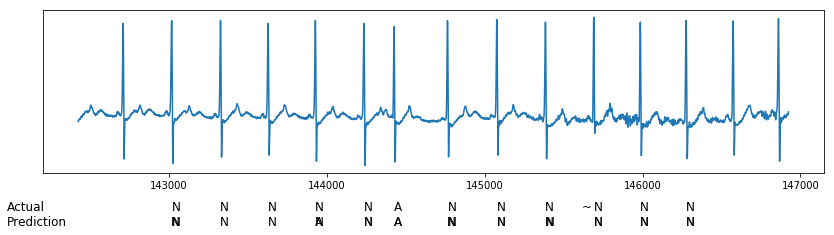

In [33]:
config = {
    'use_conv' : True,
    'ae' : [[(28, 28), [16, 8 , 8], (4,4)]], # [(28, 28), [32, 16 , 16], (4,4)]],
    'fc' : [ [3], [64,3], [128,3], [1024,3] ]
}
conv_models = evaluate_ae_models(config,  x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                    ae_epochs=20, full_model_epochs=20, load_prev_ae=True, load_prev_full=False)

### Sequential models

Running sequential model: {'filters': [32, 64, 128], 'units': [1024], 'dropout': 0.5}
Train on 16610 samples, validate on 6071 samples
Epoch 1/20
16610/16610 [==============================] - 7s - loss: 0.6528 - acc: 0.8765 - val_loss: 9.4244 - val_acc: 0.0339
Epoch 2/20
16610/16610 [==============================] - 6s - loss: 0.2054 - acc: 0.9626 - val_loss: 14.5155 - val_acc: 0.0339
Epoch 3/20
16610/16610 [==============================] - 6s - loss: 0.1681 - acc: 0.9698 - val_loss: 15.2525 - val_acc: 0.0339
Epoch 4/20
16610/16610 [==============================] - 6s - loss: 0.1479 - acc: 0.9734 - val_loss: 14.6444 - val_acc: 0.0339
Epoch 5/20
16610/16610 [==============================] - 5s - loss: 0.1336 - acc: 0.9762 - val_loss: 14.3200 - val_acc: 0.0339
Epoch 6/20
16610/16610 [==============================] - 6s - loss: 0.0974 - acc: 0.9760 - val_loss: 11.0205 - val_acc: 0.0341
Epoch 7/20
16610/16610 [==============================] - 5s - loss: 0.0690 - acc: 0.9806 - val_lo

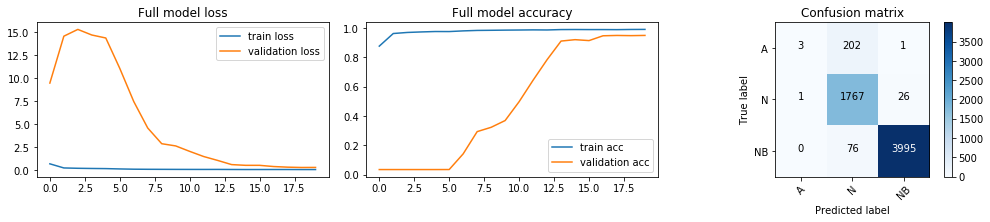

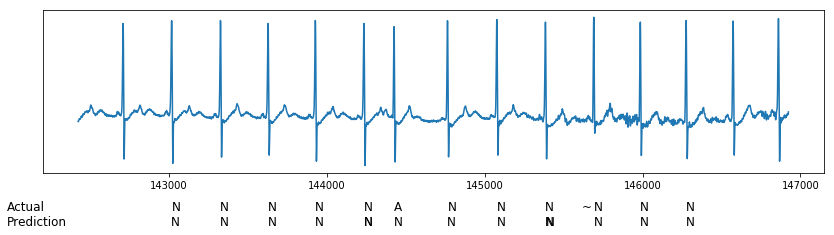

Running sequential model: {'filters': [16, 16, 16], 'units': [1024], 'dropout': 0.5}
Train on 16610 samples, validate on 6071 samples
Epoch 1/20
16610/16610 [==============================] - 4s - loss: 0.3956 - acc: 0.8515 - val_loss: 1.2873 - val_acc: 0.0339
Epoch 2/20
16610/16610 [==============================] - 2s - loss: 0.1540 - acc: 0.9582 - val_loss: 1.3687 - val_acc: 0.2955
Epoch 3/20
16610/16610 [==============================] - 2s - loss: 0.1079 - acc: 0.9689 - val_loss: 1.5561 - val_acc: 0.2955
Epoch 4/20
16610/16610 [==============================] - 2s - loss: 0.0916 - acc: 0.9731 - val_loss: 1.6487 - val_acc: 0.2955
Epoch 5/20
16610/16610 [==============================] - 2s - loss: 0.0788 - acc: 0.9771 - val_loss: 1.6151 - val_acc: 0.2955
Epoch 6/20
16610/16610 [==============================] - 2s - loss: 0.0771 - acc: 0.9771 - val_loss: 1.6434 - val_acc: 0.2957
Epoch 7/20
16610/16610 [==============================] - 2s - loss: 0.0674 - acc: 0.9804 - val_loss: 1.

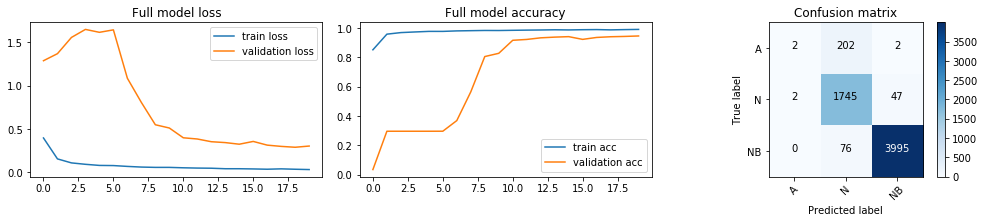

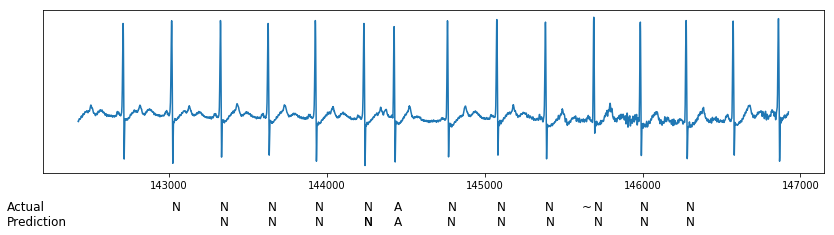

In [43]:
config = [
    {'filters' : [32, 64, 128], 'units': [1024], 'dropout': 0.5},    
    {'filters' : [16, 16, 16], 'units': [1024], 'dropout': 0.5},    
#     {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5},
#     {'filters' : [16, 32, 64, 128], 'units': [1024], 'dropout': 0.5}
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                 epochs = 20, load_prev=False)

In [21]:
def print_raport(result):
    df  = pd.DataFrame(result)
    display(df[['ae', 'fc', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [22]:
def print_seq_raport(result):
    df  = pd.DataFrame(result)    
    display(df[['filters', 'units', 'dropout', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [23]:
def print_dummy_raport(dummy):
    display(pd.DataFrame(dummy, index = [0], columns=['val_acc', 'precision', 'recall', 'f1_score']).round(2))

In [24]:
print_dummy_raport(dummy), print_raport(nn_models); 

,val_acc,precision,recall,f1_score
0,0.4,0.33,0.33,0.3


,ae,fc,val_acc,precision,recall,f1_score
0,"[784, [], 64]",[3],0.87,0.57,0.58,0.57
1,"[784, [], 64]","[32, 3]",0.88,0.57,0.59,0.58
2,"[784, [], 64]","[64, 3]",0.88,0.57,0.59,0.58
3,"[784, [256, 128], 64]",[3],0.88,0.57,0.59,0.58
4,"[784, [256, 128], 64]","[32, 3]",0.90,0.58,0.61,0.60
5,"[784, [256, 128], 64]","[64, 3]",0.89,0.58,0.60,0.59


In [34]:
print_raport(conv_models)

,ae,fc,val_acc,precision,recall,f1_score
0,"[(28, 28), [16, 8, 8], (4, 4)]",[3],0.90,0.59,0.61,0.60
1,"[(28, 28), [16, 8, 8], (4, 4)]","[64, 3]",0.92,0.60,0.63,0.61
2,"[(28, 28), [16, 8, 8], (4, 4)]","[128, 3]",0.93,0.60,0.63,0.62
3,"[(28, 28), [16, 8, 8], (4, 4)]","[1024, 3]",0.94,0.95,0.65,0.64


In [40]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[1024],0.3,0.95,0.84,0.66,0.64
1,"[16, 32, 64]",[1024],0.5,0.95,0.95,0.66,0.65
2,"[16, 32, 64]",[1024],0.7,0.94,0.88,0.66,0.64
3,"[8, 16, 32]",[1024],0.5,0.94,0.95,0.66,0.66


In [42]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[4, 8, 16]",[1024],0.5,0.94,0.83,0.67,0.66
1,"[4, 8, 16, 32]",[1024],0.5,0.92,0.77,0.62,0.62
2,"[8, 16, 32]",[1024],0.5,0.95,0.87,0.66,0.64


In [44]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[32, 64, 128]",[1024],0.5,0.95,0.87,0.66,0.65
1,"[16, 16, 16]",[1024],0.5,0.95,0.78,0.65,0.64


### Train validate on all data

Running sequential model: {'filters': [16, 32, 64], 'units': [2048], 'dropout': 0.5}
Successfully loaded weights
Train on 166101 samples, validate on 60711 samples
Epoch 1/2
166101/166101 [==============================] - 38s - loss: 0.0621 - acc: 0.9847 - val_loss: 0.2192 - val_acc: 0.9579
Epoch 2/2
166101/166101 [==============================] - 36s - loss: 0.0535 - acc: 0.9870 - val_loss: 0.1582 - val_acc: 0.9590
             precision    recall  f1-score   support

          A       0.57      0.07      0.13      1766
          N       0.89      0.99      0.94     18471
         NB       1.00      0.98      0.99     40474

avg / total       0.95      0.96      0.95     60711



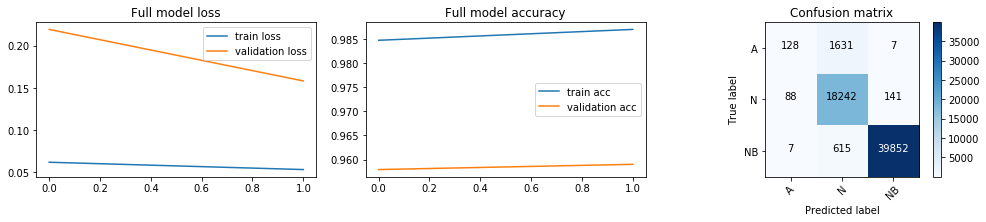

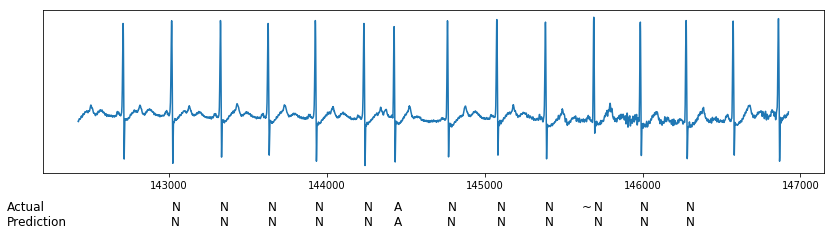

In [56]:
config = [
    {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 2, load_prev=True)

In [53]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[1024],0.5,0.96,0.84,0.7,0.71


In [55]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[2048],0.5,0.95,0.89,0.68,0.69


In [57]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]",[2048],0.5,0.96,0.82,0.68,0.69
